## Tutorial on the pullback operation with collision avoidance spec

---

In [1]:
import casadi as ca
import numpy as np
from fabrics.diffGeometry.spec import Spec

#### 1. Simple collision avoidance spec

We will create a simple spec that describes collision avoidance behavior.\
$\mathbf{x}$ here is the distance to the obstacle, and the spec is defined on the task space $\mathcal{X}$.

Spec $(\mathbf{M}, \mathbf{f})_\mathcal{X}$:

\begin{align}
\mathbf{M}\ddot{\mathbf{x}} + \mathbf{f} = \mathbf{0} \\
with: \\
\mathbf{M} &= \begin{pmatrix} 1 \end{pmatrix} \\
\mathbf{f} &= \begin{pmatrix} \frac{-3}{\mathbf{x}} || \dot{\mathbf{x}} ||^2_2 \end{pmatrix} \\
\end{align}


In [2]:
x = ca.SX.sym('x', 1)
xdot = ca.SX.sym('xdot', 1)
M = ca.SX([[1.0]])
f = ca.vcat([-3.0/x[0] * ca.norm_2(xdot)**2])
simple_spec = Spec(M, f=f, x=x, xdot=xdot)
simple_spec.concretize()

#### 2. Obstacle

Let us first define an sphere obstacle with the following position and radius:

\begin{align}
\mathbf{q}_{obs} &= \begin{pmatrix} 1 \\ 0 \end{pmatrix} \\
r_{obs} &= 0.5
\end{align}


In [3]:
from mpscenes.obstacles.sphere_obstacle import SphereObstacle
circle_dict = {
    'type': 'SphereObstacle',
    'geometry': {
        'position': [1.0, 0.0],
        'radius': 0.5,
    }
}
obstacle = SphereObstacle(name="CircleObstacle", content_dict = circle_dict)

#### 3. Differential map

Now we need to create a differential map $\phi: \mathcal{Q} \rightarrow \mathcal{X}$ between distance task space $\mathcal{X}$ and robot configuration space $\mathcal{Q}$.

\begin{align}
\phi(\mathbf{q}) = \frac{||\mathbf{q} - \mathbf{q}_{obs}||_2}{r_{obs}} - 1
\end{align}


In [4]:
from fabrics.diffGeometry.diffMap import DifferentialMap
from fabrics.helpers.variables import Variables
q = ca.SX.sym('q', 2)
qdot = ca.SX.sym('qdot', 2)
variables = Variables(state_variables={'q': q, 'qdot': qdot})
phi = ca.norm_2(q - obstacle.position())/obstacle.radius() - 1
diff_map = DifferentialMap(phi, variables)

#### 4. Pullback operation

Using the differential map $\phi$, the spec can be pulled to the configuration space as $(\mathbf{M}, \mathbf{f})_\mathcal{Q}$ from the task space as $(\mathbf{M}, \mathbf{f})_\mathcal{X}$ using the pullback operation:

\begin{align}
(\mathbf{M}, \mathbf{f})_\mathcal{Q} = pull_{\phi} (\mathbf{M}, \mathbf{f})_\mathcal{X} = \left(\mathbf{J}^T\mathbf{M}\mathbf{J}, \mathbf{J}^T(\mathbf{f} + \mathbf{M}\mathbf{\dot{J}}\mathbf{\dot{q}})\right)
\end{align}

The pullback operation is derived using the differential map's Jacobian $\mathbf{J} = \partial_{\mathbf{q}}\phi $ and $\ddot{\mathbf{x}} = \mathbf{J}\mathbf{\ddot{q}} + \mathbf{\dot{J}}\mathbf{\dot{q}}$ as follows:
\begin{align}
pull_{\phi} (\mathbf{M}, \mathbf{f})_\mathcal{X} = \mathbf{J}^T(\mathbf{M}\ddot{\mathbf{x}} + \mathbf{f}) &= \mathbf{J}^T\left(\mathbf{M}(\mathbf{J}\mathbf{\ddot{q}} + \mathbf{\dot{J}}\mathbf{\dot{q}}) + \mathbf{f}\right) \\
&= (\mathbf{J}^T\mathbf{M}\mathbf{J})\mathbf{\ddot{q}} + \mathbf{J}^T(\mathbf{f} + \mathbf{M}\mathbf{\dot{J}}\mathbf{\dot{q}})
\end{align}

In the next cell, the simple collision avoidance spec is pulled back to the configuration space and rewriten in the motion policy form with concretize.

In [5]:
pulled_spec = simple_spec.pull(diff_map)
pulled_spec.concretize()

### Planar simulation of simple collision avoidance spec

Test the spec inside a planar simulation environment.\
The spec produces a trajectory which will be visualized by the environment.

In [6]:
import gym
import numpy as np
import planarenvs.point_robot
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#### 1. Run the simulation to create the trajectory

In [7]:
env = gym.make("point-robot-acc-v0", render=True, dt=0.01)
init_pos = np.array([-1.0, 0.1])
init_vel = np.array([1.3, 0.0])
ob = env.reset(pos=init_pos, vel=init_vel)
env.add_obstacle(obstacle)
n_steps = 1000
positions = np.zeros((n_steps, 2))
for i in range(n_steps):
    x = ob['joint_state']['position']
    positions[i] = x
    xdot = ob['joint_state']['velocity']
    M, h, action = pulled_spec.evaluate(q=x, qdot=xdot)
    ob, _, _, _ = env.step(action)
env.close()

#### 2. Visualize the trajectory

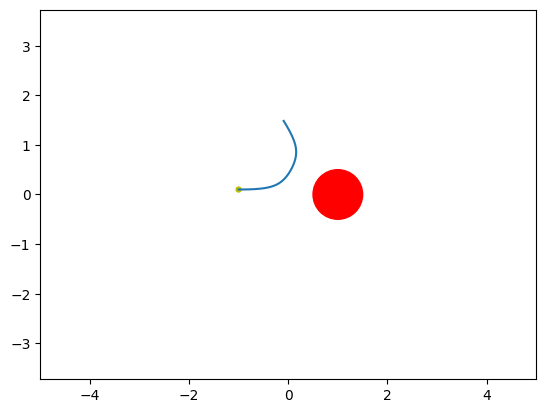

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
axs.plot(positions[:,0], positions[:,1])
axs.axis('equal')
axs.set_xlim(-5,5)
axs.set_ylim(-5,5)
initial_location = plt.Circle((positions[:,0][0], positions[:,1][0]), radius=0.05, color='y')
obst1 = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r')
axs.add_patch(initial_location)
axs.add_patch(obst1)
plt.show()